### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pickle
filename=data_dir+'/US_Weather_BBBBBSBS.csv'
List=pickle.load(open(filename,'rb'))
df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

12471
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       TMAX|USC00177523|    31|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     2|[00 4F 00 4F 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     6|[20 50 00 00 E0 D...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     4|[90 D5 E0 D0 00 4...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     1|[00 C6 00 D3 00 D...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT DISTINCT(station) FROM weather\n"
print Query
df1 = sqlContext.sql(Query)
print df1.show()

SELECT DISTINCT(station) FROM weather

+-----------+
|    station|
+-----------+
|USW00014745|
|USC00278614|
|USC00275072|
|US1MAES0010|
|CA008201336|
|USC00271678|
|USC00270100|
|USC00272302|
|US1MAES0003|
|USW00054772|
|USC00196977|
|US1NHBK0007|
|USC00275532|
|US1MECM0002|
|USC00275371|
|USC00275880|
|USC00192369|
|US1NHRC0007|
|USC00176902|
|USC00176881|
+-----------+
only showing top 20 rows

None


In [24]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBBSBBBB'
file_index='BBBBBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/Users/rafaliang/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12471
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     27.4| 43.5914| -70.2989|       TMAX|USC00177523|    31|[00 7E 00 7E 00 7...|1997.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     2|[00 4F 00 4F 00 0...|1975.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     6|[20 50 00 00 E0 D...|1976.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     4|[90 D5 E0 D0 00 4...|1977.0|BBBBBSBS|
|    240.8|    43.9|    -71.3|       TMAX|USC00278612|     1|[00 C6 00 D3 00 D...|1978.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Select data for a particular station and measurement type

In [44]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USC00271678')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMIN' and station='USC00271678'
25 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     66.1| 43.2167| -71.5167|       TMIN|USC00271678|     1|[80 54 80 D8 40 D...|1885.0|BBBBBSBS|
|     66.1| 43.2167| -71.5167|       TMIN|USC00271678|     3|[80 51 80 CD 80 4...|1886.0|BBBBBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(25, 365)

In [27]:
STAT['TMIN']

{'Cov': array([[ 41.51243455,  19.7351645 ,   9.18071964, ...,   5.38370598,
          10.51094603,  11.31729945],
        [ 19.7351645 ,  37.97087701,  18.06356435, ...,   6.13192301,
           7.47165992,   6.85761901],
        [  9.18071964,  18.06356435,  37.0791999 , ...,   1.14699731,
           7.46058189,   8.22908623],
        ..., 
        [  5.38370598,   6.13192301,   1.14699731, ...,  36.57390836,
          19.60779383,  10.76360347],
        [ 10.51094603,   7.47165992,   7.46058189, ...,  19.60779383,
          37.40671729,  22.51009626],
        [ 11.31729945,   6.85761901,   8.22908623, ...,  10.76360347,
          22.51009626,  39.90713933]]),
 'E': array([-20441.5769043 , -19324.69750977, -19726.34875488, -19433.5032959 ,
        -20359.44262695, -20135.62316895, -19367.32995605, -20797.36352539,
        -22501.16894531, -23309.74121094, -23772.93164062, -22796.95654297,
        -22357.43408203, -23561.92333984, -23252.7355957 , -24713.61987305,
        -26182.57385

### Script for plotting yearly plots

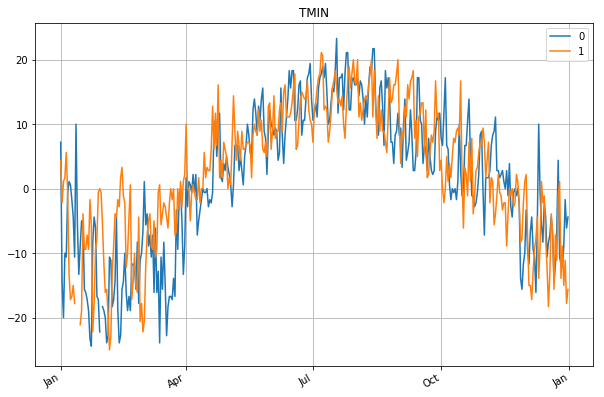

In [45]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMIN')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [29]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

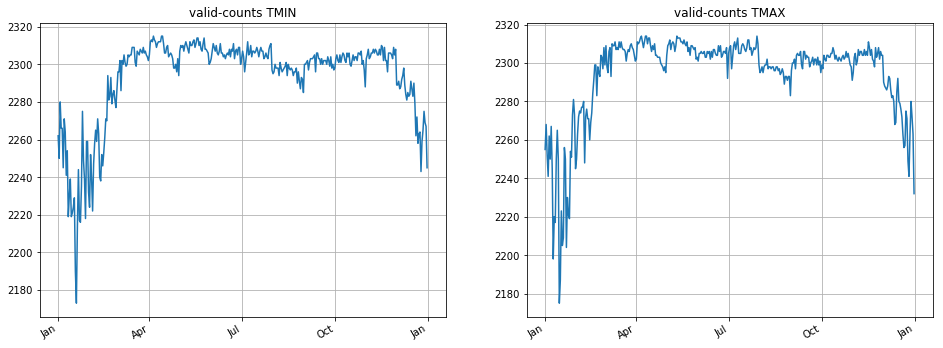

In [30]:
plot_pair(['TMIN','TMAX'],plot_valid)

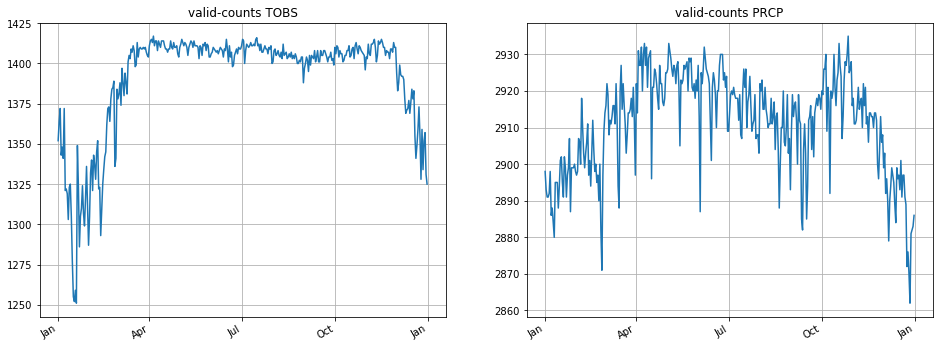

In [31]:
plot_pair(['TOBS','PRCP'],plot_valid)

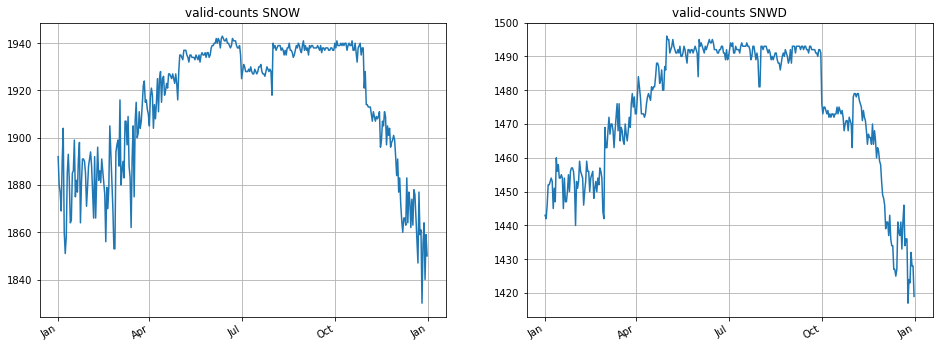

In [32]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [33]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

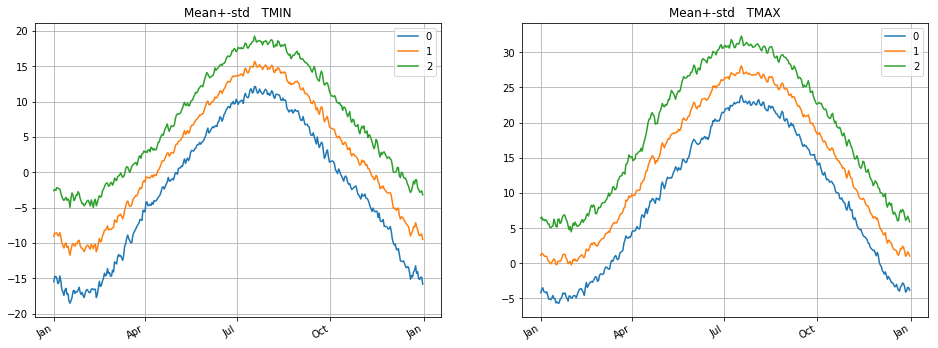

In [34]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

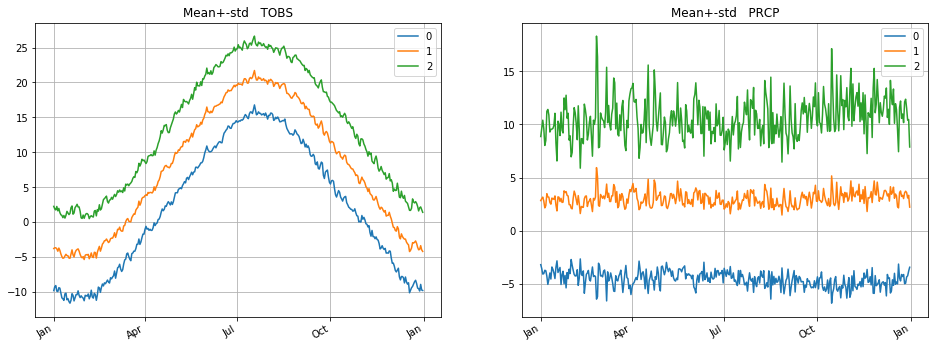

In [35]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

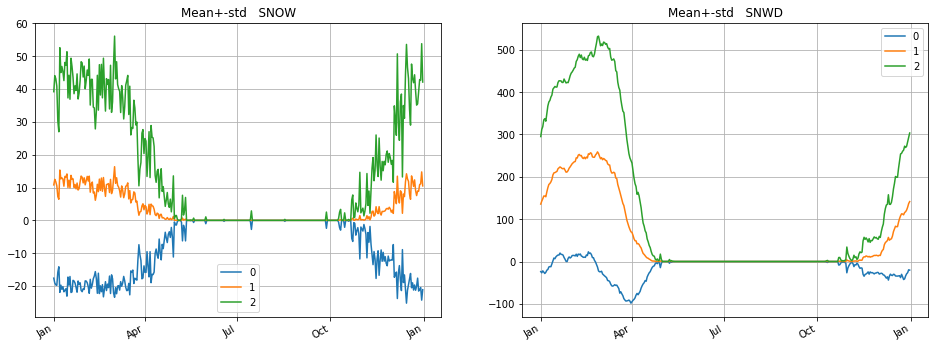

In [36]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [37]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

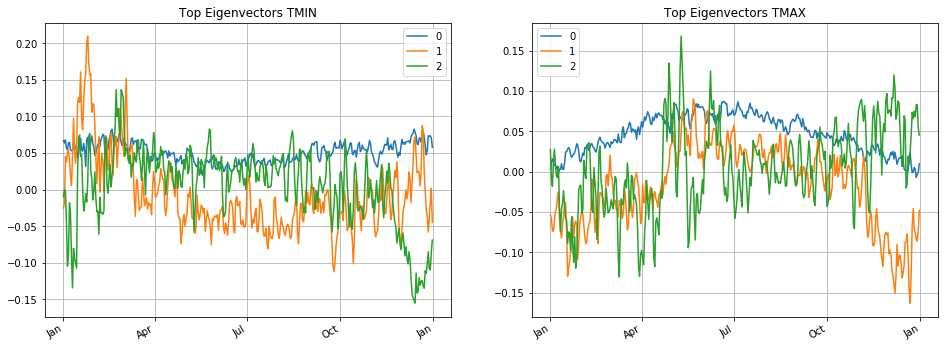

In [38]:
plot_pair(['TMIN','TMAX'],plot_eigen)

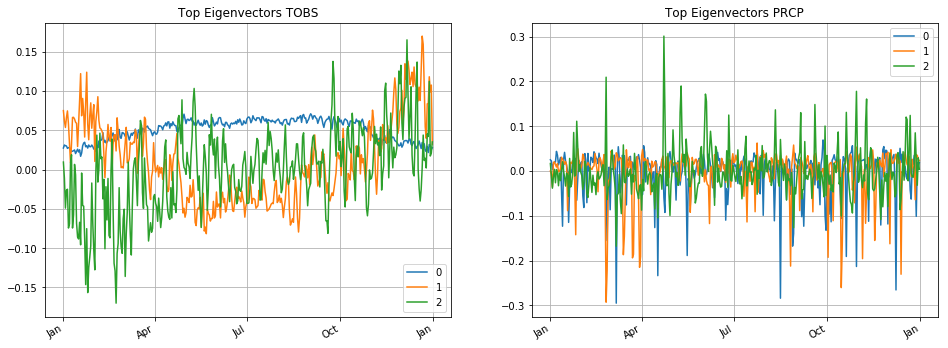

In [39]:
plot_pair(['TOBS','PRCP'],plot_eigen)

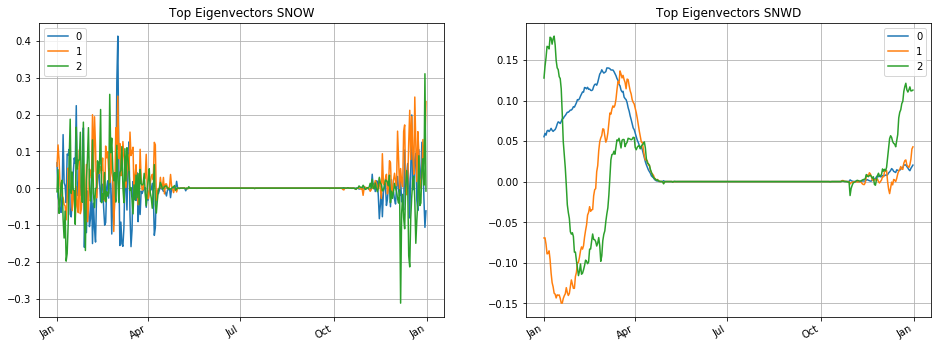

In [40]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [41]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

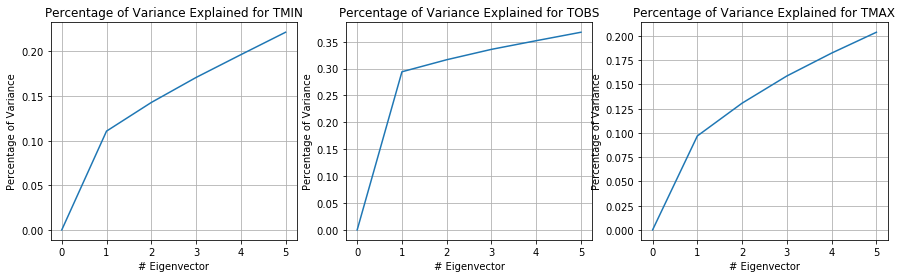

In [42]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

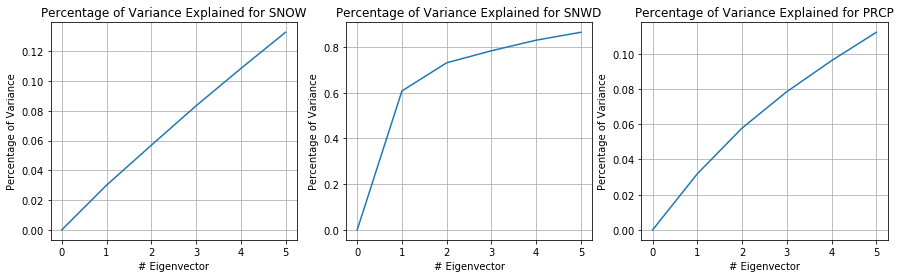

In [43]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [23]:
sc.stop()